In [9]:
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os

class AdvancedViz():

    def __init__(self, n_bins= 10, smooth_factor=10, save_figures=False,
                 data_path = "../ift6758/data/tidy/all_seasons_combined.csv",
                 rink_img = "../figures/nhl_rink-no_background.png",
                 save_path="../figures/advanced_visualizations/"):
        # load csv
        self._data = pd.read_csv(data_path).dropna(subset=['x_coord', 'y_coord'])

        # generated figures config
        self._save_figures = save_figures
        self._save_path = save_path


        # load rink img and use right side only
        self._rink_img = mpimg.imread(rink_img)
        self._rink_img = mpimg.imread(rink_img)[:, self._rink_img.shape[1] // 2 :]

        # heatmap factors
        self._n_bins = n_bins
        self._smoothing_factor = smooth_factor

        # use rink's right side coordinates
        self._data.loc[self._data["x_coord"] > 0, "y_coord"] *= -1
        self._data["x_coord"] = np.abs(self._data["x_coord"])

        # locate each shot's bin
        self._data["xbin"] = np.digitize(self._data["x_coord"], np.linspace(0, 100, self._n_bins+1)) - 1
        self._data["ybin"] = np.digitize(self._data["y_coord"], np.linspace(-42.5, 42.5, self._n_bins+1)) - 1

        # constants
        self._rink_width_feet = 100.0
        self._rink_height_feet = 85.0
        self._rink_width_pixel = self._rink_img.shape[1]
        self._rink_height_pixel = self._rink_img.shape[0]
        
    # assuming each game lasts 60 minutes
    # returns league average shot per hour in a region of the rink
    # if a team is specified, return the average for that team
    def _avg_shot_per_hour(self, season, xbin, ybin, team=None):
        df = self._data
        if not team:
            df = df[(df["season"] == season) & (df["xbin"] == xbin) & (df["ybin"] == ybin)]
            total_shots = df.shape[0]*0.5
            total_games = pd.unique(self._data[self._data["season"] == season]["game_id"]).shape[0]
        else:
            df = df[(df["season"] == season) & (df["xbin"] == xbin) & (df["ybin"] == ybin) & (df["team_name"] == team)]
            total_shots = df.shape[0]
            total_games = pd.unique(self._data[(self._data["season"] == season) & (self._data["team_name"] == team)]["game_id"]).shape[0]
        if total_games == 0:
            return 0
        return total_shots/total_games

    # map rink coords to pixel coords
    def _feet_to_pixel(self, x, axisName):
        if axisName == "x":
            return (x*self._rink_width_pixel/self._rink_width_feet) + self._rink_width_pixel/2.0
        elif axisName == "y":
            return -(x*self._rink_height_pixel/self._rink_height_feet) + self._rink_height_pixel/2.0

    # map pixel coords to rink coords
    def _pixel_to_feet(self, x, axisName):
        if axisName == "x":
            return (x*self._rink_width_feet/self._rink_width_pixel) - self._rink_width_feet/2.0
        elif axisName == "y":
            return -(x*self._rink_height_feet/self._rink_height_pixel) + self._rink_height_feet/2.0

    # generate heatmap matrix
    def _generate_heatmap_array(self, team, season, variance=0.12):

        # returns list of distances from x to yi for each yi in y
        def cartesian_mat(x,y):
            return np.sum((x-y)**2, axis=1)**0.5

        # gaussian kernel for smoothing
        def gaussian(d2, variance):
            coef = 1 / (2 * np.pi * variance)
            return coef * np.exp(-d2 / (2 * variance))

        # build initial heatmap
        heatmap = np.zeros((self._n_bins, self._n_bins))
        for x, y in np.ndindex(heatmap.shape):
            team_avg = self._avg_shot_per_hour(season, x, y, team)
            avg = self._avg_shot_per_hour(season, x, y)
            heatmap[x,y] = team_avg - avg

        # build finer grid
        x, y = np.indices(heatmap.shape)
        heatmap = np.column_stack((x.ravel(), y.ravel(), heatmap.ravel()))
        s = self._smoothing_factor
        heatmap_smooth = np.repeat(heatmap, s**2, axis=0)
        offsets = np.array([[i/s, j/s, 0] for i in range(s) for j in range(s)])
        heatmap_smooth += np.tile(offsets, (heatmap.shape[0], 1))
        heatmap_smooth[:,2] = 0
        
        # compute the smoothed heatmap
        for x in heatmap_smooth:
            distance_mat = cartesian_mat(x[:2], heatmap[:,0:2])
            weights = gaussian(distance_mat,variance)
            x[2] = np.sum(heatmap[:,2]*weights) / np.sum(weights)
        
        return heatmap_smooth

    def _generate_heatmap_img(self, heatmap_array):
        arr = heatmap_array
        xi = np.linspace(arr[:,0].min(), arr[:,0].max(), self._rink_width_pixel)
        yi = np.linspace(arr[:,1].min(), arr[:,1].max(), self._rink_height_pixel)
        XI, YI = np.meshgrid(xi, yi)
        ZI = griddata((arr[:,0], arr[:,1]), arr[:,2], (XI, YI), method='linear', fill_value=0)
        return ZI
        
    def draw_heatmap(self, team, season, variance=0.13):

        plt.rcParams['figure.figsize'] = (5, 6)
        
        # set tick values to represent rink coords
        plt.xlabel("feet")
        plt.ylabel("feet")
        xticks_pixel = np.linspace(0, self._rink_width_pixel, 11)
        yticks_pixel = np.linspace(0, self._rink_height_pixel, 5)
        xticks_feet = [self._pixel_to_feet(x, "x")+50 for x in np.linspace(0, self._rink_width_pixel, 11)]
        yticks_feet = [self._pixel_to_feet(y, "y") for y in np.linspace(0, self._rink_height_pixel, 5)]
        plt.yticks(xticks_pixel, xticks_feet)
        plt.xticks(yticks_pixel, yticks_feet)

        
        
        plt.imshow(np.rot90(self._generate_heatmap_img(self._generate_heatmap_array(team, season, variance))),
                                              extent=[0, self._rink_height_pixel, 0, self._rink_width_pixel], 
                                              cmap='seismic', alpha=1, aspect='auto',  vmin=-1, vmax = 1)
        plt.colorbar(label='Excess shot rate per hour')
        
        plt.imshow(np.rot90(self._rink_img), extent=[0, self._rink_height_pixel, 0, self._rink_width_pixel])
        

        plt.title(f'''
Excess shot rate per hour
{team}
{season}-{season+1}
''' )
                
        if self._save_figures:
            file_path = self._save_path + f"{team.lower().replace(' ', '_')}_{season}.png"
            if not os.path.exists(self._save_path):
                os.makedirs(self._save_path)
            if not os.path.exists(file_path):
                plt.savefig(file_path, dpi=300, bbox_inches='tight')
                
        plt.show()




                
        

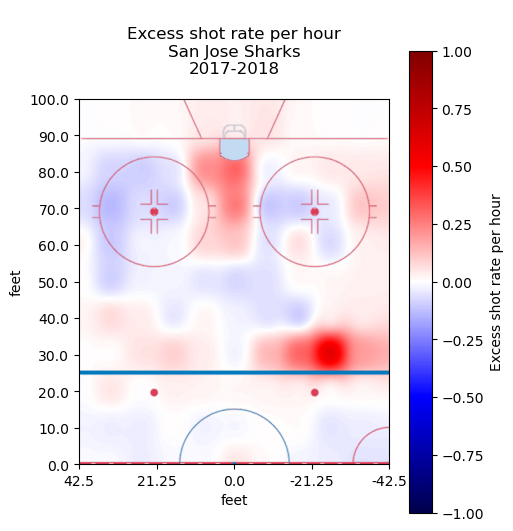

In [10]:
viz = AdvancedViz(n_bins=10, smooth_factor=10, save_figures=True)
team = "San Jose Sharks"
viz.draw_heatmap(team, 2017, 0.13)
#viz.draw_heatmap(team, 2020, 0.2)
